# High-Frequency Effects and Modelling on FX Market in Response to US Macroeconomic Data Releases

## Steps:
1. <span style="color:green">Research and Planning
    * <span style="color:green">Define clear research goals and objectives
    * <span style="color:green">Decide on macroeconomic events and FX pairs</span>
2. Literature Review
    * Review past papers
    * <span style="color:green">Identify gaps (model that does stress testing, probability w/ price range, capturing retracement/correction)<span style="color:green">
3. <span style="color:green">Data Collection and Processing
    * <span style="color:green">Identify data sources
    * <span style="color:green">Collect FX pairs (date, minute interval, open, low, high, close)
    * <span style="color:green">Collect macroeconomic events (date, expected value, actual value)
    * <span style="color:green">Merge datasets
    * <span style="color:green">Keep only data with the macro events (not whole month but only on data releases)
    * <span style="color:green">Do some analysis for data dimensionality (e.g., analysis whether to keep 10 minutes before and 10 minutes after only of the data release)</span>  
4. Exploratory Analysis
    * <span style="color:green">Feature importance (which macro event brings more volume)
    * <span style="color:green">Barchart with 6 double bars for each event how many events (expected == actual) vs (expected != actual) and what is their volatility difference.
    * Variance before/on/after the events 
        * Volatility but also min and max (before 5 min - on the minute - after 10 minutes). For min/max (var) for example find the min and max for all these 3 ranges. For volatility calculate the average of these 3 

5. <span style="color:red">Model Development
    * Create some probabilistic TS model based on historical data
    * Create a class/function to take input of a pair, expected value of macro data, and minute after event to give some price 
6. <span style="color:red">Backtesting and Market Simulation
    * KPIs and statistical measurement of model on test data (can be same as past)
    * Future event test (already known)
range and classification with confidence interval
7. <span style="color:red">Results and Discusion
    * Interpret market reactions to economic data
    * Compare model accuracy with benchmarks</span>

----------------------

# <span style="color:blue">Libraries</span>

In [1]:
# Libraries for data fetching
from polygon import RESTClient

# Libraries for data analysis
import pandas as pd
import numpy as np
import math
from IPython.display import display

# Libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

# Libraries for time handling
import time  
from datetime import timedelta

# Libraries for feature importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

----------------------

# <span style="color:blue">Data Retrieval</span>

* Data Collection FX pair tickers (symbols) for **Polygon.io**:
    * **USD/EUR** 🠆 C:USD/EUR
    * **USD/GBP** 🠆 C:USD/GBP
    * **USD/CNY** 🠆 C:USD/CHF  
    
    
* Macroeconomic events **Bloomberg Terminal (KCL)** (macro_data_bloomberg.csv):
    * **INTR** (every 6-weeks)
    * **CPI** (MoM)
    * **GDP** (QoQ)
    * **PCE** (MoM)
    * **UNRATE** (MoM)
    * **PMI** (MoM)

In [2]:
def polygon_get_fx_data(fx_pair, interval, start_date, end_date, api_key='0GbCWQKVtPfEMJvPmc1n50psE3zsW1c8'):
    """
    Retrieve historical FX data from Polygon.io.

    Parameters:
    - interval (str): The interval for the data ('1m', '5m', '1h', '1d').
    - start_date (str): The start date in 'YYYY-MM-DD' format.
    - end_date (str): The end date in 'YYYY-MM-DD' format.
    - api_key (str): Polygon.io API key.

    Returns:
    - pd.DataFrame: A DataFrame containing historical USD/CNY forex data.
    """
    try:
        # Bring the fx pair ticker to Polygon's format
        fx_pair_polygon_formated = "C:" + str(fx_pair)

        client = RESTClient(api_key)

        # Request data
        data_request = client.get_aggs(
            ticker=fx_pair_polygon_formated, 
            multiplier=1, 
            timespan=interval,
            from_=start_date, 
            to=end_date
        )
    
        # Convert response to DataFrame
        df = pd.DataFrame(data_request)
        
        # Check if data is returned
        if df.empty:
            print("No data found.")
            return None

        # Convert timestamp to datetime format and set Datetime as an index
        df["Datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
        df.set_index("Datetime", inplace=True)
        
        # Drop columns not needed
        df = df.drop(columns=["otc", "transactions", "timestamp"])
        
        # Rename columns to align with yf for the feature engineering and merging later on
        df = df.rename(columns={"high": "High", "low": "Low", "close": "Adj Close", "volume": "Volume"})
        df = df.rename_axis(f'{fx_pair}', axis=1)
        
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None
        
        
def fetch_and_combine_fx_data(macro_df, pair):
    """
    Fetches and combines minute-level FX data for a given pair and list of macro event dates.

    Parameters:
    - macro_df: DataFrame with datetime index representing macro event dates.
    - pair: FX pair symbol (e.g. 'USD/EUR').

    Returns:
    - Combined DataFrame with volatility and price metrics, prefixed by pair.
    """
    # Get index values to list
    macro_dates_list = macro_df.index.strftime("%Y-%m-%d").tolist()
    
    # Initialize empty DataFrame
    data_df = pd.DataFrame()  

    for i, date in enumerate(macro_dates_list):
        fx_data = calculate_volatility(polygon_get_fx_data(pair, "minute", date, date))
        
        # Add pair symbol as a prefix to columns (excluding Datetime)
        fx_data = fx_data.rename(columns={col: f"{pair}_{col}" for col in fx_data.columns if col != "Datetime"})
        
        # Append the retrieved data to the main DataFrame
        data_df = pd.concat([data_df, fx_data])

        # Implement sleep logic for API limitations
        if (i + 1) % 5 == 0:  
            time.sleep(70)
        else:
            time.sleep(2) 

    return data_df


# Read the CSV file retrieved from Bloomberg Terminal        
macro_df = pd.read_csv("macro_bloomberg_data.csv")

----------------------

# <span style="color:blue">Data Preprocessing</span>
1. Replace '--' to null
2. DateTime format (some years to 2 digits some 4 e.g., 2025 and 25)
3. Convert to DateTime
4. Replace the % to decimals and convert to float

In [3]:
def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Finds for  '--' values and converts them to NaN. 
    Afterwards, drop rows where Expected and Actual are NaN.
    
    Parameters:
    - df ()
    """
    # Missing values convert from '--' to NaN
    df.replace('--', np.nan, inplace=True)

    # Drop rows where Expected and Actual are missing
    df = macro_df.dropna(subset=["Expected", "Actual"], how="all")
    
    return df



def standardize_datetime_format(df: pd.DataFrame, column_name="Date Time") -> pd.DataFrame:
    """
    Standardizes the Date Time column to the format MM/DD/YYYY HH:MM,
    converts it to a datetime datatype, sets it as the index, and sorts the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the column to be formatted.
    - column_name (str): The name of the column to standardize.

    Returns:
    - pd.DataFrame: The DataFrame with the standardized datetime format, 
                    set as index, and sorted.
    """
    def fix_date_format(date_str):
        # Try parsing with two-digit year format first
        dt = pd.to_datetime(date_str, format='%m/%d/%y %H:%M', errors='coerce')
        
        # If conversion fails, try four-digit year format
        if pd.isnull(dt):
            dt = pd.to_datetime(date_str, format='%m/%d/%Y %H:%M', errors='coerce')
        
        return dt  # Return as datetime object

    # Apply the function to convert to datetime
    df = df.copy(deep=True)
    df["Datetime"] = df[column_name].astype(str).apply(fix_date_format)
    
    # Drop rows where conversion failed
    df = df.dropna(subset=["Datetime"])
    # Drop previous 'Date Time'
    df.drop(columns=['Date Time'], inplace=True)

    # Convert the column to datetime dtype
    df["Datetime"] = pd.to_datetime(df["Datetime"])

    # Set Date Time as index
    df = df.set_index("Datetime")

    # Sort DataFrame by the Date Time index
    df = df.sort_index()

    return df



def convert_percentage_to_numeric(df: pd.DataFrame, columns=["Expected", "Actual", "Prior"]) -> pd.DataFrame:
    """
    Converts percentage values in specified columns to numerical float values.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing percentage values.
    - columns (list): List of column names to convert.

    Returns:
    - pd.DataFrame: DataFrame with percentage values converted to floats.
    """
    for col in columns:
        df[col] = df[col].astype(str).str.replace('%', '', regex=True).astype(float)
    
    return df



def clean_macro_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Drops the 'Event' column and renames 'Ticker' values to standardized names.

    Parameters:
    - df (pd.DataFrame): The macroeconomic DataFrame.

    Returns:
    - pd.DataFrame: Cleaned DataFrame with renamed tickers.
    """
    
    # Drop the 'Event' column
    df = df.drop(columns=["Event"], errors="ignore")

    # Dictionary mapping for renaming
    ticker_mapping = {
        "UNRATE": "UNRATE",
        "CPI_MoM": "CPI",
        "INTR": "INTR",
        "PCE_MoM": "PCE",
        "GDP_QoQ": "GDP",
        "PMI": "PMI"
    }

    # Rename cols
    df["Ticker"] = df["Ticker"].replace(ticker_mapping)

    return df


def extract_relevant_fx_data(fx_data, macro_df, start, end)-> pd.DataFrame:
    """
    Extracts FX data around each macro event within a specified time window.

    Parameters:
    - fx_data: DataFrame with datetime index containing FX price and volatility data.
    - macro_df: DataFrame with macro event times as index and event metadata.
    - start: Minutes before the event to include.
    - end: Minutes after the event to include.

    Returns:
    - Combined DataFrame of FX data with added macro event details.
    """
    extracted_data = []

    for event_time in macro_df.index:
        start_time = event_time - pd.Timedelta(minutes=start)
        end_time = event_time + pd.Timedelta(minutes=end)

        # Check if any timestamps in the range exist in fx_data
        available_times = fx_data.index[(fx_data.index >= start_time) & (fx_data.index <= end_time)]

        if available_times.empty:  
            continue  # Skip if no matching timestamps exist

        filtered_fx = fx_data.loc[available_times].copy()

        # Add event details from macro_df
        if event_time in macro_df.index:
            filtered_fx["Ticker"] = macro_df.loc[event_time, "Ticker"]
            filtered_fx["Expected"] = macro_df.loc[event_time, "Expected"]
            filtered_fx["Actual"] = macro_df.loc[event_time, "Actual"]
            filtered_fx["Prior"] = macro_df.loc[event_time, "Prior"]
            filtered_fx["Surprise"] = macro_df.loc[event_time, "Surprise"]

        extracted_data.append(filtered_fx)

    # Set Datetime index
    final_df = pd.concat(extracted_data).reset_index()
    final_df = final_df.rename(columns={"index": "Datetime"}).set_index("Datetime")
    # Drop duplicates if they exist
    final_df = final_df[~final_df.index.duplicated(keep="first")]
    
    return final_df

----------------------

# <span style="color:blue">Feature Engineering</span>

In [4]:
def surprise_calculation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the surprise (difference) of Expected vs Actual.
    
    Parameters:
    - df (pd.DataFrame): macro economic data

    Returns:
    - pd.DataFrame: Original dataframe plus the surprise column.
    """
    
    df["Surprise"] = df["Actual"] - df["Expected"]
    return df


def calculate_volatility(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the average volatility dynamically.

    Parameters:
    - df (pd.DataFrame): FX data.

    Returns:
    - pd.DataFrame: The original DataFrame with added 'Volatility', 'Average_Volatility', and 'Volatility_Multiplier' columns.
    """

    if df is None or df.empty:
        print("Error: DataFrame is empty or invalid.")
        return None
    if "Adj Close" in df.columns:
        # Compute Volatility
        df['Volatility'] = np.abs(np.log(df['Adj Close'] / df['Adj Close'].shift(1)))
    else:
        df['Volatility'] = np.abs(np.log(df['Close'] / df['Close'].shift(1)))
        
    # Compute Average Volatility based on each trading day
    df['Average_Volatility'] = df['Volatility'].mean()
    # Compute Volatility Multiplier
    df['Volatility_Multiplier'] = round(df['Volatility'] / df['Average_Volatility'],2)

    return df

------------

# <span style="color:blue">Plotting Functions</span>

In [170]:
########################################################################
################### Event Volatility Time Analysis #####################

def plot_time_differences(time_differences, avg_start, avg_end):
    """
    Plots the distribution of time differences from event timestamps,
    highlighting where the most volatile timeframes begin and end.
    Filters to display only x-axis range from -70 to +70 minutes.
    """
    # Filter values in the desired range
    start_diffs = [diff[0] for diff in time_differences if -70 <= diff[0] <= 70]
    end_diffs = [diff[1] for diff in time_differences if -70 <= diff[1] <= 70]

    # Plot setup
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    # KDE plots for smoother curves
    sns.histplot(start_diffs, bins=50, kde=True, color="royalblue", label="Start Time", alpha=0.5, edgecolor='white')
    sns.histplot(end_diffs, bins=50, kde=True, color="tomato", label="End Time", alpha=0.5, edgecolor='white')

    # Add vertical reference lines
    plt.axvline(avg_start, color="blue", linestyle="--", linewidth=2)
    plt.axvline(avg_end, color="red", linestyle="--", linewidth=2)
    plt.axvline(0, color="black", linestyle="-", linewidth=2)

    # Add text labels with padding
    y_max = plt.ylim()[1]
    plt.text(avg_start + 0.5, y_max * 0.9, f"{avg_start:.0f} min", color="blue", fontsize=12, fontweight="bold")
    plt.text(avg_end + 0.5, y_max * 0.9, f"{avg_end:.0f} min", color="red", fontsize=12, fontweight="bold")
    plt.text(0.6, y_max * 0.9, "Event Time\n(0 min)", color="black", fontsize=12, fontweight="bold")

    # Set plot limits and labels
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.xlim(-20, 20)
    plt.xlabel("Time Difference from Event (in minutes)", fontsize=12, fontweight="bold")
    plt.ylabel("Frequency", fontsize=12, fontweight="bold")
    plt.title("Distribution of Most Volatile 16-Minute Timeframes", fontsize=12, fontweight="bold")
    plt.legend(fontsize=11, frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


###########################################################################
########################### Feature Importance ############################

def plot_event_importance(importance_df):
    """
    Plots the feature importance of macroeconomic events on Volatility.

    Args:
        importance_df (pd.DataFrame): Feature importance dataframe.
    """

    # Plot
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=importance_df, x="Volatility_Impact", y="Event", palette="Blues_r", dodge=False)
    for bar in ax.patches:
        bar.set_height(bar.get_height() * 0.7)
    
    plt.title("Feature Importance of Macroeconomic Events on Volatility", fontsize=12, fontweight='bold')
    plt.xlabel("Importance Score", fontsize=12)
    plt.ylabel("Event", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    plt.show()


def plot_event_importance_by_year(importance_df):
    """
    Plots the feature importance of macroeconomic events on Volatility across different years,
    sorted based on 2023 importance.

    Parameters:
    - importance_df (pd.DataFrame): Dataframe with feature importance scores per year.
    """

    # Define colors for each year
    color_palette = {2023: "#1f4b99", 2024: "#2a7ccc", 2025: "#87bfff"}  # Dark blue, blue, light blue

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(
        data=importance_df,
        x="Volatility_Impact",
        y="Event",
        hue="Year",
        palette=color_palette,
        ax=ax
    )

    # Plot customizations
    plt.title("Feature Importance of Macroeconomic Events on Volatility (2023-2025)", fontsize=12, fontweight='bold')
    plt.xlabel("Importance Score", fontsize=12)
    plt.ylabel("Event", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Year", fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Show plot
    plt.show()
    pass


###########################################################################
########################## Correlation Analysis ###########################

def analyze_usd_pairs_correlation(df, macro_df):
    """
    Analyze the correlation between USD pairs around macroeconomic event times.
    
    Parameters:
    - df (pd.DataFrame): FX market data with datetime index.
    - macro_df (pd.DataFrame): Macro event timestamps.
    
    Returns:
    - None, just a plot.
    """
    
    # Selecting only the AdjClose columns for the three currency pairs
    adj_close_data = final_data[['USDEUR_AdjClose', 'USDGBP_AdjClose', 'USDCNH_AdjClose']]

    # Drop any rows with null values
    adj_close_data = adj_close_data.dropna()

    # Compute correlation matrix
    corr_matrix = adj_close_data.corr()

    # Plot heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Correlation Heatmap - AdjClose of Currency Pairs", fontsize=12, fontweight='bold')
    plt.show()
    

###########################################################################
##################### Analysts Expectations vs Actual #####################

def plot_expectations_vs_actual(df: pd.DataFrame):
    # Ensure datetime format and event segmentation
    df = df.reset_index(drop=True)
    df['EventID'] = df.index // 16
    event_blocks = df.groupby('EventID').first()

    # Correctness of predictions
    event_blocks['CorrectPrediction'] = event_blocks['Expected'] == event_blocks['Actual']

    # Count correct and incorrect predictions per Ticker
    correct_counts = event_blocks[event_blocks['CorrectPrediction']].groupby('Ticker').size()
    incorrect_counts = event_blocks[~event_blocks['CorrectPrediction']].groupby('Ticker').size()

    # Fill missing tickers with 0
    all_tickers = set(event_blocks['Ticker'].unique())
    correct_counts = correct_counts.reindex(all_tickers, fill_value=0)
    incorrect_counts = incorrect_counts.reindex(all_tickers, fill_value=0)

    # Sort by correct prediction counts
    sorted_tickers = correct_counts.sort_values(ascending=False).index
    correct_counts = correct_counts[sorted_tickers]
    incorrect_counts = incorrect_counts[sorted_tickers]

    # Plot
    x = range(len(sorted_tickers))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x, correct_counts, width, label='Expected == Actual', color='#1f4b99')
    bars2 = ax.bar([i + width for i in x], incorrect_counts, width, label='Expected ≠ Actual', color='#87bfff')

    # Add value labels above bars
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.2, str(int(height)),
                ha='center', va='bottom', fontsize=8)

    # Customize plot
    ax.set_xlabel('Macro Event Type', fontsize=10)
    ax.set_ylabel('Number of Events', fontsize=10)
    ax.set_title('Prediction Accuracy per Macro Event Type', fontsize=12, fontweight='bold')
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(sorted_tickers, fontsize=9)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Force integer y-ticks
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(False)  # Remove grid
    ax.legend(fontsize=9)  # Add legend
    plt.tight_layout(pad=1)
    plt.show()
    
    
###########################################################################
##################### Time_Window: Before, On, After ######################

def plot_fx_event_patterns(results_dict, fx_pairs):
    """
    Plots volatility and absolute return trends (Before, On, After) for each FX pair.

    Parameters:
    - results_dict: output from analyze_event_windows_pretty()
    - fx_pairs: list of FX pair keys (e.g. 'USDEUR_AdjClose')

    Displays 2 charts per FX pair: one for volatility, one for absolute return.
    """
    ordered_windows = ['Before', 'On', 'After']
    fig, axes = plt.subplots(len(fx_pairs), 2, figsize=(12, 8 ))

    for i, pair in enumerate(fx_pairs):
        df = results_dict[pair].copy()
        df['Time_Window'] = pd.Categorical(df['Time_Window'], categories=ordered_windows, ordered=True)
        grouped = df.groupby('Time_Window').mean(numeric_only=True)

        # Volatility trend
        axes[i, 0].plot(grouped.index, grouped['Average_Volatility'], marker='o', color='blue')
        axes[i, 0].set_title(f'{pair.replace("_AdjClose", "")}: Volatility Trend', fontweight='bold')
        axes[i, 0].set_ylabel('Volatility', fontweight='bold', color='blue')


        # Absolute return trend
        axes[i, 1].plot(grouped.index, grouped['Average_Absolute_Return'], marker='o', color='green')
        axes[i, 1].set_title(f'{pair.replace("_AdjClose", "")}: Absolute Return Trend', fontweight='bold')
        axes[i, 1].set_ylabel('Absolute Return', fontweight='bold', color='green')

    plt.tight_layout()
    plt.show()

----------------------

# <span style="color:blue">Data Analysis</span>

In [71]:
###########################################################################
######################## Most Volatile Timeframe ##########################

def find_most_volatile_16min(df, filtered_macro_df):
    """
    Finds the most volatile 16-minute timeframe for each event date in filtered_macro_df.

    Parameters:
        - df (pd.DataFrame): FX data with Datetime index.
        - filtered_macro_df (pd.DataFrame): Macro data with event timestamps as index.

    Returns:
        - dict: Most volatile timeframes for each event.
        - float: Average time difference for start and end times.
    """
    
    # Store results
    most_volatile_times = {}
    time_differences = []

    # Check if required volatility columns exist
    required_columns = ["USDEUR_Volatility", "USDGBP_Volatility", "USDCNH_Volatility"]
    
    # Compute combined average volatility
    df["Average_Volatility"] = df[required_columns].mean(axis=1)

    # Loop through each event in filtered_macro_df
    for event_date in filtered_macro_df.index:
        event_date = pd.to_datetime(event_date)

        # Filter only data for the event date
        group = df[df.index.date == event_date.date()]
        if group.empty: continue

        # Compute rolling sum of average volatility
        rolling_volatility = group["Average_Volatility"].rolling(window=7, min_periods=7).sum()
        # Get the time with the highest volatility over the exact 16-minute window
        end_time = rolling_volatility.idxmax()
        if pd.isna(end_time): continue
        start_time = end_time - timedelta(minutes=15)

        # Compute time difference from event timestamp. Convert to minutes
        diff_start = (start_time - event_date).total_seconds() / 60
        diff_end = (end_time - event_date).total_seconds() / 60

        # Store results
        most_volatile_times[event_date] = (start_time, end_time)
        time_differences.append((diff_start, diff_end))

    # Compute average time differences
    avg_diff_start = math.floor(np.mean([diff[0] for diff in time_differences]))
    avg_diff_end = math.floor(np.mean([diff[1] for diff in time_differences]))

    print(f"\nTotal events analyzed: {len(most_volatile_times)}")
    print(f"Average Time Difference: {avg_diff_start} min (start) | {avg_diff_end} min (end)")

    return most_volatile_times, avg_diff_start,  avg_diff_end, time_differences


###########################################################################
###################### Macro Data Event Importance ########################

def compute_event_importance(df):
    """
    Computes the importance of macroeconomic events on Volatility.

    Parameters:
    - df (pd.DataFrame): Dataset containing macro events and FX market data.

    Returns:
    - pd.DataFrame: Dataframe with feature importance scores.
    """

    # One-Hot Encode Event Types
    events = pd.get_dummies(df["Ticker"])  
    df = pd.concat([df, events], axis=1)

    # Define target variable (Volatility Impact)
    df["Volatility_Impact"] = df[["USDEUR_VolatilityMultiplier", 
                                  "USDGBP_VolatilityMultiplier", 
                                  "USDCNH_VolatilityMultiplier"]].mean(axis=1)

    # Features = Event Types
    X = df[events.columns]
    y_volatility = df["Volatility_Impact"]

    # Train Random Forest Regressor
    rf_volatility = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_volatility.fit(X, y_volatility)

    # Compute feature importance
    importance_df = pd.DataFrame({
        "Event": X.columns,
        "Volatility_Impact": rf_volatility.feature_importances_
    }).sort_values(by="Volatility_Impact", ascending=False)

    return importance_df


def compute_event_importance_by_year(df, years=[2023, 2024, 2025]):
    """
    Computes the importance of macroeconomic events on Volatility for specified years.

    Parameters:
    - df (pd.DataFrame): Dataset containing macro events and FX market data.
    - years (list): List of years to analyze.

    Returns:
    - pd.DataFrame: Dataframe with feature importance scores for each year.
    """

    importance_list = []

    for year in years:
        df_year = df[df.index.year == year].copy()

        if df_year.empty:
            continue

        # One-Hot Encode Event Types
        events = pd.get_dummies(df_year["Ticker"])  
        df_year = pd.concat([df_year, events], axis=1)

        # Define target variable (Volatility Impact)
        df_year["Volatility_Impact"] = df_year[["USDEUR_VolatilityMultiplier", "USDGBP_VolatilityMultiplier", "USDCNH_VolatilityMultiplier"]].mean(axis=1)

        # Define features (Event Types)
        X = df_year[events.columns]
        y_volatility = df_year["Volatility_Impact"]

        # Train Random Forest Regressor
        rf_volatility = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_volatility.fit(X, y_volatility)

        # Store feature importance
        importance_df = pd.DataFrame({
            "Event": X.columns,
            "Volatility_Impact": rf_volatility.feature_importances_,
            "Year": year
        })

        importance_list.append(importance_df)

    # Combine all years
    combined_importance = pd.concat(importance_list)

    # Sort by 2023 event importance
    sort_order = combined_importance[combined_importance["Year"] == 2024].sort_values(by="Volatility_Impact", ascending=False)["Event"]
    combined_importance["Event"] = pd.Categorical(combined_importance["Event"], categories=sort_order, ordered=True)

    return combined_importance

###########################################################################
################ Analysis Before, On and After the event ##################

def analyze_event_windows(df):
    """
    Analyzes return and volatility across 'Before', 'On', and 'After' windows 
    for each macro event and FX pair.

    Parameters:
    - df: DataFrame with macro-labeled FX data, 16 rows per event.

    Returns:
    - Dictionary of DataFrames, one per FX pair, with grouped stats by Event Type and Time Window.
    """
    df = df.reset_index(drop=True)
    # Assign unique event IDs and minute index within each event block
    df['EventID'] = df.index // 16
    df['MinuteIndex'] = df.groupby('EventID').cumcount()
    df['Event_Type'] = df.groupby('EventID')['Ticker'].transform('first')
    
    # Label time window based on minute index
    def window_label(i):
        if i <= 4:
            return 'Before'
        elif i == 5:
            return 'On'
        else:
            return 'After'

    df['Time_Window'] = df['MinuteIndex'].apply(window_label)

    fx_pairs = ['USDEUR_AdjClose', 'USDGBP_AdjClose', 'USDCNH_AdjClose']
    results = {}
    
    # Compute returns and volatility metrics for each FX pair
    for pair in fx_pairs:
        df[f'{pair}_Return'] = df.groupby('EventID')[pair].pct_change().fillna(0)
        returns = df.groupby(['Event_Type', 'Time_Window'])[f'{pair}_Return'].agg(
            Minimum_Return='min',
            Maximum_Return='max',
            Average_Absolute_Return=lambda x: x.abs().mean()
        )
        vol_col = f'{pair.replace("AdjClose", "Volatility")}'
        volatility = df.groupby(['Event_Type', 'Time_Window'])[vol_col].mean().to_frame(name='Average_Volatility')
        results[pair] = returns.join(volatility).reset_index()
    
    # Sort by Event Type and ordered Time Window 
    ordered_window = ['Before', 'On', 'After']
    for pair in results:
        df = results[pair]
        df['Time_Window'] = pd.Categorical(df['Time_Window'], categories=ordered_window, ordered=True)
        results[pair] = df.sort_values(['Event_Type', 'Time_Window'])

    return results

----------------------

# <span style="color:blue">Macro data preprocessed</span>

In [7]:
# Macroeconomics DataFrame
macro_df = clean_macro_dataframe(
                surprise_calculation(
                    convert_percentage_to_numeric(
                        standardize_datetime_format(
                            handle_missing_values(macro_df)
                        )
                   )
                )
           )

# Getting data for the past 2 years
filtered_macro_df = macro_df[macro_df.index >= "2023-03-10"].copy()

macro_df

,Ticker,Expected,Actual,Prior,Surprise
Datetime,,,,,
2020-01-10 13:30:00,UNRATE,3.50,3.50,3.50,0.0
2020-01-14 13:30:00,CPI,0.30,0.20,0.30,-0.1
2020-01-29 19:00:00,INTR,1.75,1.75,1.75,0.0
2020-01-30 13:30:00,GDP,2.00,2.10,2.10,0.1
2020-01-31 13:30:00,PCE,0.20,0.30,0.20,0.1
...,...,...,...,...,...
2025-01-29 19:00:00,INTR,4.50,4.50,4.50,0.0
2025-01-30 13:30:00,GDP,2.60,2.30,3.10,-0.3
2025-01-31 13:30:00,PCE,0.30,0.30,0.10,0.0


----------------------

# <span style="color:blue">Create final df with all Pairs and Macro events</span>
1. Fetch all data for the past 2 years for each pair 'fetch_and_combine_fx_data(macro_df, pair)'
2. Merge the datasets 
3. Fetch only data with events (-5 +10 from the event)

In [8]:
# Save them to save time next time you run them
# eur = fetch_and_combine_fx_data(filtered_macro_df, "USDEUR")
# gbp = fetch_and_combine_fx_data(filtered_macro_df, "USDGBP")
# cnh = fetch_and_combine_fx_data(filtered_macro_df, "USDCNH")

# Load CSVs
eur = pd.read_csv("data/USDEUR_data.csv")
gbp = pd.read_csv("data/USDGBP_data.csv")
cnh = pd.read_csv("data/USDCNH_data.csv")

for df in [eur, gbp, cnh]:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=True)
    df['Datetime'] = df['Datetime'].dt.strftime("%d/%m/%Y %H:%M")
    df.set_index('Datetime', inplace=True)
    
# Merge all three dataframes on 'Datetime' index, keeping only matching timestamps
merged_df = eur.merge(gbp, left_index=True, right_index=True, how="inner") \
               .merge(cnh, left_index=True, right_index=True, how="inner")

# Ensure the index is in datetime format
merged_df.index = pd.to_datetime(merged_df.index, format="%d/%m/%Y %H:%M")

# Sort the merged DataFrame by 'Datetime' index
merged_df.sort_index(inplace=True)

# Merged DataFrame before the filtering out all datetimes except for the most volatile time around the event
merged_df

,USDEUR_High,USDEUR_Low,USDEUR_AdjClose,USDEUR_Volume,USDEUR_vwap,USDEUR_Volatility,USDEUR_AverageVolatility,USDEUR_VolatilityMultiplier,USDGBP_High,USDGBP_Low,...,USDGBP_AverageVolatility,USDGBP_VolatilityMultiplier,USDCNH_High,USDCNH_Low,USDCNH_AdjClose,USDCNH_Volume,USDCNH_vwap,USDCNH_Volatility,USDCNH_AverageVolatility,USDCNH_VolatilityMultiplier
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-10 00:00:00,0.94466,0.9443,0.94459,55,0.9446,NaN,0.000144,NaN,0.83872,0.838490,...,0.000156,NaN,6.97835,6.97635,6.97751,169,6.9776,NaN,0.000106,NaN
2023-03-10 00:01:00,0.94464,0.9444,0.94457,71,0.9446,0.000021,0.000144,0.15,0.83887,0.838620,...,0.000156,1.15,6.97814,6.97672,6.97749,109,6.9775,0.000003,0.000106,0.03
2023-03-10 00:02:00,0.94461,0.9444,0.94448,84,0.9445,0.000095,0.000144,0.66,0.83890,0.838560,...,0.000156,0.38,6.97801,6.97646,6.97784,121,6.9775,0.000050,0.000106,0.48
2023-03-10 00:03:00,0.94452,0.9443,0.94430,67,0.9445,0.000191,0.000144,1.33,0.83881,0.838590,...,0.000156,0.54,6.97786,6.97586,6.97711,103,6.9770,0.000105,0.000106,0.99
2023-03-10 00:04:00,0.94439,0.9441,0.94427,60,0.9443,0.000032,0.000144,0.22,0.83870,0.838480,...,0.000156,0.54,6.97776,6.97593,6.97659,86,6.9768,0.000074,0.000106,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-12 23:55:00,0.96238,0.9621,0.96220,32,0.9623,0.000187,0.000109,1.71,0.80330,0.803110,...,0.000112,0.78,7.31005,7.30872,7.30991,12,7.3097,0.000008,0.000050,0.16
2025-02-12 23:56:00,0.96231,0.9620,0.96220,30,0.9623,0.000000,0.000109,0.00,0.80318,0.803148,...,0.000112,0.00,7.31003,7.30874,7.30987,14,7.3098,0.000005,0.000050,0.11
2025-02-12 23:57:00,0.96231,0.9621,0.96220,41,0.9623,0.000000,0.000109,0.00,0.80319,0.803140,...,0.000112,0.00,7.30982,7.30860,7.30974,13,7.3095,0.000018,0.000050,0.35


-----------

#  <span style="color:blue"> Final DataFrame </span>

In [9]:
# Final dataframe after event time analysis
final_data = extract_relevant_fx_data(merged_df, macro_df, 5, 10)

final_data

,USDEUR_High,USDEUR_Low,USDEUR_AdjClose,USDEUR_Volume,USDEUR_vwap,USDEUR_Volatility,USDEUR_AverageVolatility,USDEUR_VolatilityMultiplier,USDGBP_High,USDGBP_Low,...,USDCNH_Volume,USDCNH_vwap,USDCNH_Volatility,USDCNH_AverageVolatility,USDCNH_VolatilityMultiplier,Ticker,Expected,Actual,Prior,Surprise
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-10 13:25:00,0.94447,0.943841,0.94436,149,0.9442,0.000169,0.000144,1.18,0.83399,0.83356,...,284,6.9578,0.000183,0.000106,1.73,UNRATE,3.4,3.6,3.4,0.2
2023-03-10 13:26:00,0.94442,0.944000,0.94417,117,0.9443,0.000201,0.000144,1.40,0.83392,0.83360,...,226,6.9580,0.000135,0.000106,1.28,UNRATE,3.4,3.6,3.4,0.2
2023-03-10 13:27:00,0.94425,0.943800,0.94425,115,0.9441,0.000085,0.000144,0.59,0.83398,0.83357,...,212,6.9578,0.000045,0.000106,0.42,UNRATE,3.4,3.6,3.4,0.2
2023-03-10 13:28:00,0.94431,0.943931,0.94428,165,0.9442,0.000032,0.000144,0.22,0.83420,0.83370,...,317,6.9562,0.000306,0.000106,2.90,UNRATE,3.4,3.6,3.4,0.2
2023-03-10 13:29:00,0.94429,0.943900,0.94410,197,0.9441,0.000191,0.000144,1.33,0.83413,0.83283,...,349,6.9550,0.000023,0.000106,0.22,UNRATE,3.4,3.6,3.4,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-12 13:36:00,0.96915,0.968220,0.96859,192,0.9687,0.000341,0.000109,3.12,0.80751,0.80701,...,341,7.3221,0.000184,0.000050,3.67,CPI,0.3,0.5,0.4,0.2
2025-02-12 13:37:00,0.96893,0.968300,0.96872,176,0.9687,0.000134,0.000109,1.23,0.80760,0.80723,...,345,7.3217,0.000085,0.000050,1.69,CPI,0.3,0.5,0.4,0.2
2025-02-12 13:38:00,0.96873,0.968060,0.96828,195,0.9683,0.000454,0.000109,4.16,0.80757,0.80696,...,359,7.3213,0.000161,0.000050,3.21,CPI,0.3,0.5,0.4,0.2


-----------

# <span style="color:blue"> Most Volatile timeframe on Event </span>


Total events analyzed: 130
Average Time Difference: -5 min (start) | 10 min (end)


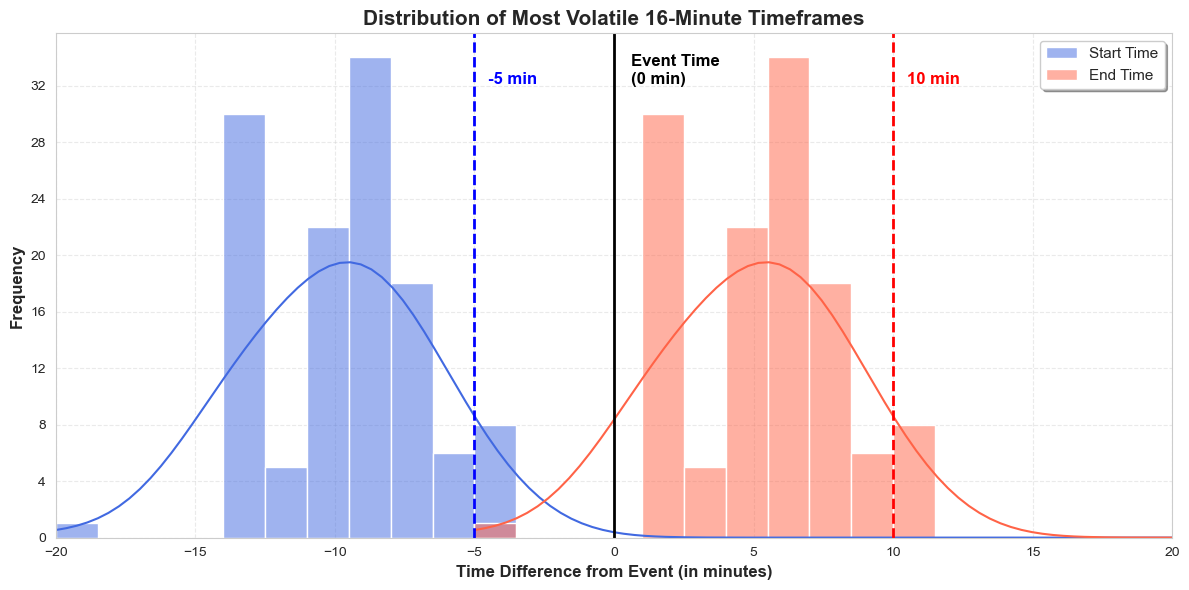

In [113]:
# Run the function
most_volatile_times, avg_start, avg_end, time_differences = find_most_volatile_16min(final_data, filtered_macro_df)

# Plot of most volatile timeframe
plot_time_differences(time_differences, avg_start, avg_end)

------------

#  <span style="color:blue"> Economic Data Seasonality report </span>

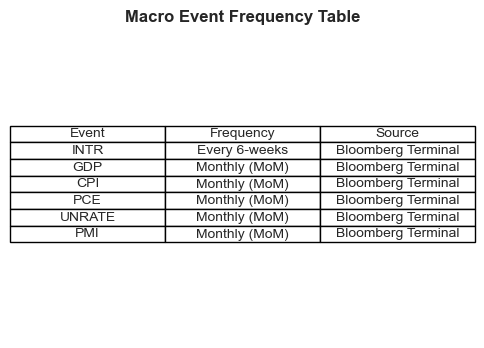

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis("tight")
ax.axis("off")
table_data = [["INTR", "Every 6-weeks", "Bloomberg Terminal"],
              ["GDP", "Monthly (MoM)", "Bloomberg Terminal"],
              ["CPI", "Monthly (MoM)", "Bloomberg Terminal"],
              ["PCE", "Monthly (MoM)", "Bloomberg Terminal"],
              ["UNRATE", "Monthly (MoM)", "Bloomberg Terminal"],
              ["PMI", "Monthly (MoM)", "Bloomberg Terminal"]]

table = ax.table(cellText=table_data, colLabels=["Event", "Frequency", "Source"], cellLoc="center", loc="center")

# Display the table
plt.title("Macro Event Frequency Table", fontsize=12, fontweight='bold')
plt.show()

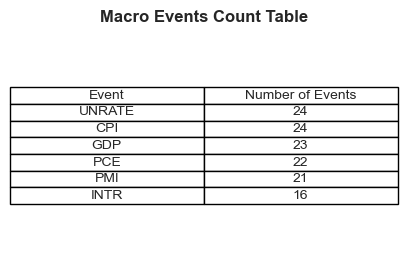

In [21]:
# Reassign EventIDs by every 16 rows (as each event has 16 minutes - data rows)
df = final_data.reset_index(drop=True)
df['EventID'] = df.index // 16

# Extract the first row of each event block to identify the event type
event_blocks = df.groupby('EventID').first()

# Count how many events per macro event type
event_counts_by_block = event_blocks['Ticker'].value_counts()
total_events_block = event_blocks.shape[0]
event_table_data = [[ticker, count] for ticker, count in event_counts_by_block.items()]

# Create the figure and axis for the table
fig, ax = plt.subplots(figsize=(5, 3))
ax.axis("tight")
ax.axis("off")

# Create the table
table = ax.table(cellText=event_table_data, colLabels=["Event", "Number of Events"], cellLoc="center", loc="center")

# Display the table
plt.title("Macro Events Count Table", fontsize=12, fontweight='bold')
plt.show()

------------

#  <span style="color:blue"> Macro Event Importance Analysis </span>

1. Do some feature importance to keep the major macro data releases and do detailed analysis on these ones.
2. Explain that based on discussion with Risk Manager... from case studies these are athe most importants and refer to other papers too.

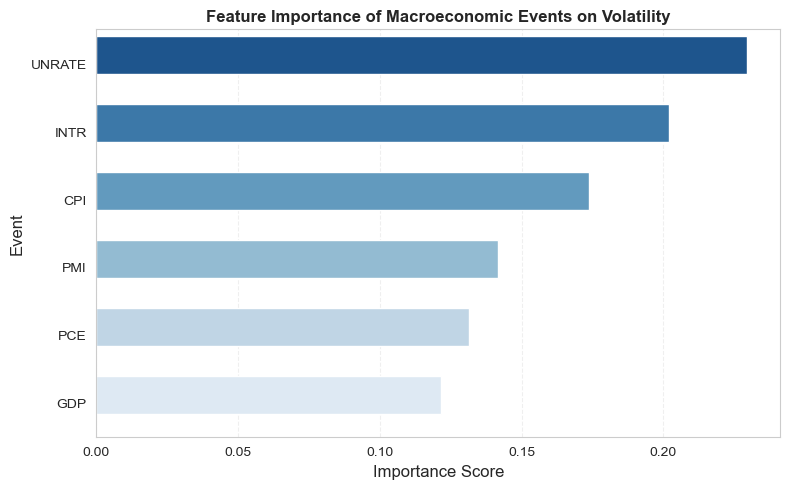

In [171]:
# Compute Event Importance based on Volatility
importance_results = compute_event_importance(final_data)

# Plot the events with their importance
plot_event_importance(importance_results)

------------

# <span style="color:blue"> Prior vs Now (volatility and importance)</span>

1. What is the volatility of the events over the past 3 years? This correlates with the one above (the one above is a combination of all 3 years)

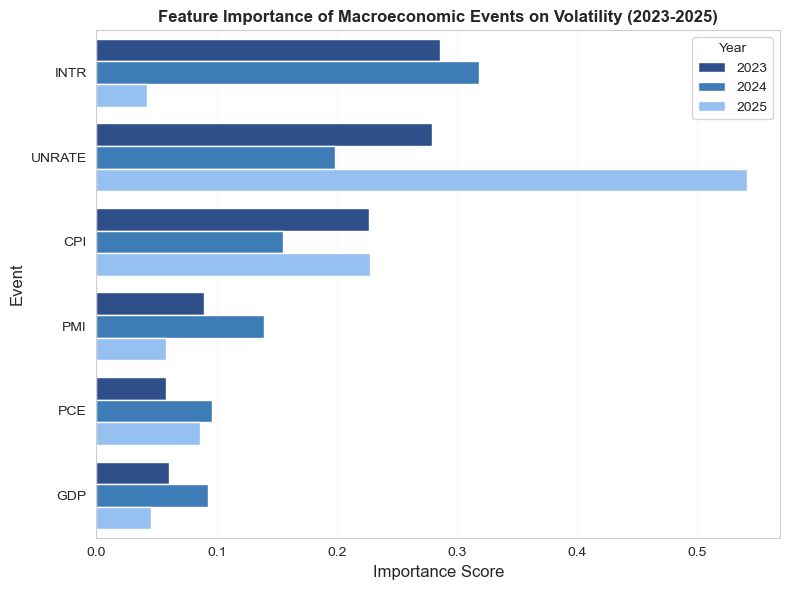

In [172]:
# Macro Data Event importance by year (2023-2025)
importance_results = compute_event_importance_by_year(final_data, years=[2023, 2024, 2025])

# Plot the results
plot_event_importance_by_year(importance_results)

# <span style="color:blue"> Expectations vs Actual </span>

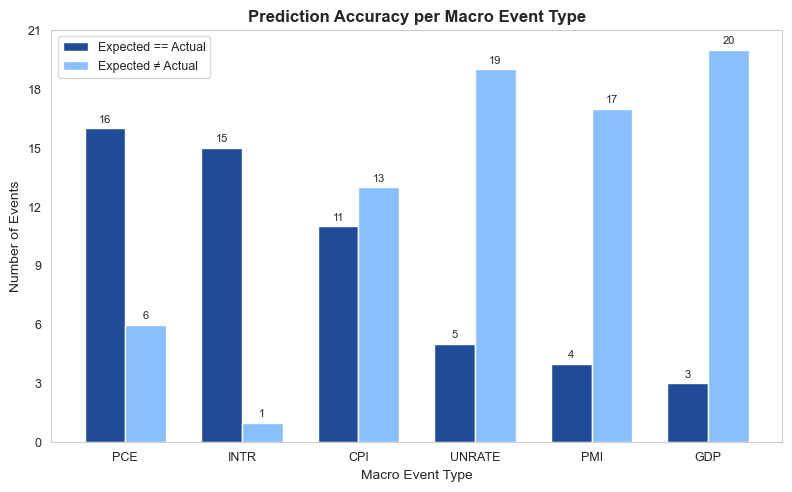

In [173]:
# Plot number of grouped events where analysts predicted the macro data accurately
plot_expectations_vs_actual(df)

# <span style="color:red"> Jump (R4 p32) </span> <span style="color:blue">- Volatility Increase on each event table - Data Release Trend: Before/On/After

1. Charts
2. Need to find Var (and expected JUMP)
    * Shall I set Var such as +- |abs_return| ?
    * Shall I set Var such as min | max ?

In [25]:
# Run the analysis and get individual DataFrames
fx_analysis_results = analyze_event_windows(final_data)
usdeur_df = fx_analysis_results['USDEUR_AdjClose']
usdgbp_df = fx_analysis_results['USDGBP_AdjClose']
usdcnh_df = fx_analysis_results['USDCNH_AdjClose']

data = [usdgbp_df, usdeur_df, usdcnh_df]
titles = ['USDGBP', 'USDEUR', 'USDCNH']

for i in range(len(data)):
    print(f"*** {titles[i]} ***")
    display(data[i])
    print("\n")

*** USDGBP ***


,Event_Type,Time_Window,Minimum_Return,Maximum_Return,Average_Absolute_Return,Average_Volatility
1,CPI,Before,-0.005445,0.004543,0.000316,0.000354
2,CPI,On,-0.000816,0.001681,0.000385,0.000385
0,CPI,After,-0.024083,0.022094,0.001056,0.000266
4,GDP,Before,-0.000497,0.000834,0.000125,0.000149
5,GDP,On,-0.000573,0.000875,0.000200,0.000200
3,GDP,After,-0.014468,0.005965,0.000422,0.000170
7,INTR,Before,-0.004329,0.004096,0.000517,0.000554
8,INTR,On,-0.003039,0.001225,0.000561,0.000561
6,INTR,After,-0.009882,0.016949,0.000946,0.000287
10,PCE,Before,-0.000885,0.001044,0.000152,0.000179




*** USDEUR ***


,Event_Type,Time_Window,Minimum_Return,Maximum_Return,Average_Absolute_Return,Average_Volatility
1,CPI,Before,-0.004420,0.004295,0.000276,0.000313
2,CPI,On,-0.001341,0.001798,0.000431,0.000431
0,CPI,After,-0.017816,0.023874,0.000858,0.000256
4,GDP,Before,-0.000738,0.001438,0.000152,0.000183
5,GDP,On,-0.000490,0.000639,0.000161,0.000161
3,GDP,After,-0.005612,0.006162,0.000398,0.000181
7,INTR,Before,-0.003880,0.003884,0.000476,0.000517
8,INTR,On,-0.003627,0.001741,0.000687,0.000687
6,INTR,After,-0.012858,0.014347,0.000856,0.000248
10,PCE,Before,-0.001224,0.000914,0.000144,0.000165




*** USDCNH ***


,Event_Type,Time_Window,Minimum_Return,Maximum_Return,Average_Absolute_Return,Average_Volatility
1,CPI,Before,-0.001735,0.001061,0.000122,0.000139
2,CPI,On,-0.000930,0.000767,0.000217,0.000217
0,CPI,After,-0.020148,0.022506,0.000683,0.000146
4,GDP,Before,-0.000250,0.000395,0.000071,0.000083
5,GDP,On,-0.000256,0.000478,0.000116,0.000116
3,GDP,After,-0.002582,0.003762,0.000221,0.000089
7,INTR,Before,-0.001308,0.000872,0.000142,0.000163
8,INTR,On,-0.000262,0.001071,0.000199,0.000199
6,INTR,After,-0.013586,0.013430,0.000561,0.000124
10,PCE,Before,-0.000363,0.000602,0.000077,0.000089


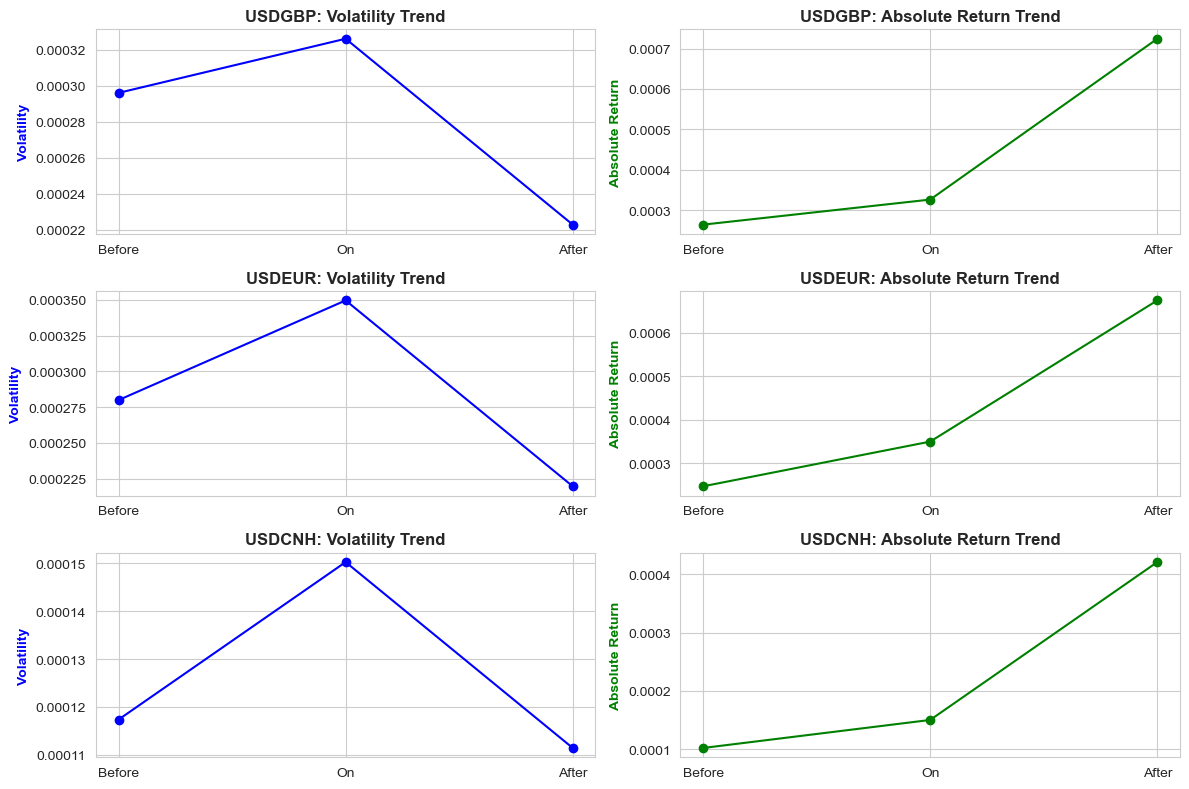

In [174]:
# Call the function for all three pairs
plot_fx_event_patterns(fx_analysis_results, ['USDGBP_AdjClose', 'USDEUR_AdjClose', 'USDCNH_AdjClose'])

# <span style="color:blue"> Correlation of USD pairs and DXY price movements </span>

1. Correlation heatmap
2. Identify which one moves first if not all together to see for arbritrage opportunity

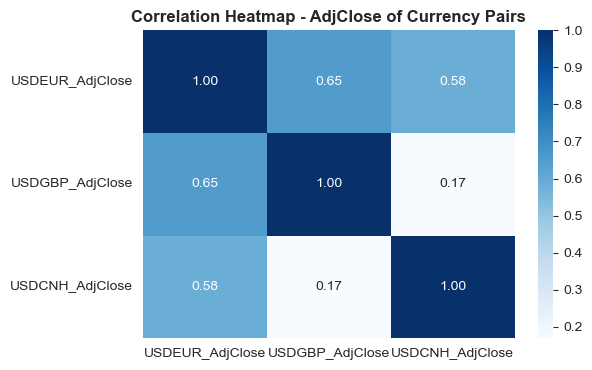

In [175]:
# Run the function
analyze_usd_pairs_correlation(final_data, macro_df)

-------